In [1]:
# -----------------------------OpenSG------------------------------
# -------------------Timoshenko Beam Model using 2DSG--------------
#
# This code is developed by multiscale structural analysis laboratory 
# at Purdue University under the supervision of Prof. Wenbin Yu. This 
# code is intended for general purpose usage for performing accurate
# and precise structural analysis. The code is based on Mechanics of 
# Structure Genome (MSG) theory to perform homogenization and 
# dehomogenization. 
#
# -----------------------------mesh import-------------------------------
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.interpolate import griddata
%matplotlib inline
plt.style.use('classic')
import time
import scipy

# ** User Input- .msh file name**
fname= "SG40_2D"
import subprocess
subprocess.check_output('dolfin-convert  '+ fname+ '.msh  '+ fname +'.xml', shell=True)
mesh = Mesh(fname + ".xml")
subdomains = MeshFunction("size_t", mesh, fname + "_physical_region.xml")
#facets = MeshFunction("size_t", mesh, fname + "_facet_region.xml")

#----------------------------- Material Data Input-----------------------------

# **The sequence of material initialization is corresponding to subdomain (physical_region) sequence**

# GELCOAT-1
E1,E2,E3=3.4400E+09, 3.4400E+09, 3.4400E+09
G12,G13,G23= 1.3230E+09, 1.3230E+09, 1.3230E+09
v12,v13,v23 = 0.3,0.3,0.3
material_parameters=[(E1,E2,E3,G12,G13,G23,v12,v13,v23)]

# Gtriax-2
E1,E2,E3= 2.8700E+10, 1.6600E+10, 1.6700E+10
G12,G13,G23= 8.4000E+09, 3.4900E+09, 3.4900E+09
v12,v13,v23 = 0.50, 0.17, 0.0
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# GUNI- 3
E1,E2,E3= 4.4600E+10, 1.7000E+10, 1.6700E+10
G12,G13,G23= 3.2700E+09, 3.5000E+09, 3.4800E+09
v12,v13,v23 = 0.26,0.26,0.35
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# FOAM- 4
E1,E2,E3= 1.2920E+08, 1.2920E+08, 1.2920E+08
G12,G13,G23= 4.8947E+07, 4.8947E+07, 4.8947E+07
v12,v13,v23 = 0.32,0.32,0.32
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# CarbonUD 5
E1,E2,E3= 1.1450E+11, 8.3900E+09, 8.3900E+09
G12,G13,G23= 5.9900E+09,5.9900E+09, 5.9900E+09
v12,v13,v23 = 0.27,0.27,0.27
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

nphases = len(material_parameters)

## -----------------------------Functions-----------------------------

x = SpatialCoordinate(mesh)
Eps2T=as_tensor([(1,0,0,0,0,0),
                (0,0,0,0,x[0],-x[1]),
                (x[1],0,0,0,0,0),
                (-x[0],0,0,0,0,0)]) 

Eps2=as_tensor([(1,0,x[1],-x[0]),
                (0,0,0,0),
                (0,0,0,0),
                (0,0,0,0),
               (0,x[0],0,0),
               (0,-x[1],0,0)])

def eps(v):
    E1=as_vector([0,v[1].dx(0),v[2].dx(1),v[1].dx(1)+v[2].dx(0),v[0].dx(1),v[0].dx(0)])
    return as_tensor([(E1[0],0.5*E1[5],0.5*E1[4]),(0.5*E1[5],E1[1],0.5*E1[3]),(0.5*E1[4],0.5*E1[3],E1[2])]),E1

def gamma_h(v):
    E1=as_vector([0,v[1].dx(0),v[2].dx(1),0.5*(v[1].dx(1)+v[2].dx(0)),0.5*(v[0].dx(1)),0.5*(v[0].dx(0))])
    return E1

def sigma(v, i,Eps):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,eps(v)[1]+Eps)
    return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])]),C

def gamma_l(v):
    E1= as_vector([v[0],0,0,0, v[2],v[1]])
    return as_tensor([(E1[0],0.5*E1[5],0.5*E1[4]),(0.5*E1[5],E1[1],0.5*E1[3]),(0.5*E1[4],0.5*E1[3],E1[2])]),E1

def sigma_gl(v, i, Eps):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,gamma_l(v)[1]+Eps)
    return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])])

# -----------------------------FE Function Space-----------------------------

Ve = VectorElement("CG", mesh.ufl_cell(), 1,dim=3) 
Re = VectorElement("R", mesh.ufl_cell(), 0,dim=4)
W = FunctionSpace(mesh, MixedElement([Ve, Re]))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
Eps= as_vector((1,0,0,0,0,0))
dx = Measure('dx')(domain=mesh, subdomain_data=subdomains)

c1=lamb_[0]*dv[0]+lamb_[1]*dv[1]+lamb_[2]*dv[2]
c2=dlamb[0]*v_[0]+dlamb[1]*v_[1]+dlamb[2]*v_[2]
c3=lamb_[3]*(dv[1].dx(1)-dv[2].dx(0))+dlamb[3]*(v_[1].dx(1)-v_[2].dx(0))

# Omega
omega=assemble(sum([Constant(1)*dx(i)for i in range(nphases)]))

# -----------------------------Assembled matrices-----------------------------

F1=sum([inner(sigma_gl(dv,i,Eps),gamma_l(v_)[0])*dx(i) for i in range(nphases)])
a1=lhs(F1)+(c1+c2+c3)*dx

A1=assemble(a1)
from scipy.sparse import csr_matrix
ai, aj, av= as_backend_type(A1).mat().getValuesCSR()
Dll=csr_matrix((av, aj, ai))
Dll=Dll.toarray()

xx=len(Dll)

# --------------Getting Dle

Dle=np.zeros((xx,4))
for p in range(4):
    
        Eps=Eps2[:,p] 
        F1=sum([inner(sigma_gl(dv,i,Eps),gamma_l(v_)[0])*dx(i) for i in range(nphases)])
        
        a1=lhs(F1)+(c1+c2+c3)*dx
        L1 = rhs(F1)      
        w1 = Function(W) 
        solve(a1 == L1, w1,[])       
        Dle[:,p]= -assemble(L1).get_local() # Dhe matrix formation
        
# --------------Getting Dhl
Eps=Eps2[:,0] 
F_dhl=sum([inner(sigma(dv,i,Eps)[0],gamma_l(v_)[0])*dx(i) for i in range(nphases)]) 

a3=lhs(F_dhl)+(c1+c2+c3)*dx
L3 = rhs(F_dhl)
w3 = Function(W) 
solve(a3 == L3, w3,[])  

x3=len(assemble(L3).get_local()) 

A3=assemble(a3)
ai, aj, av= as_backend_type(A3).mat().getValuesCSR()
Dhl=csr_matrix((av, aj, ai))
Dhl=Dhl.toarray()

# --------------Getting Dhe, V0 

V0 = np.zeros((xx,4))
Dhe=np.zeros((xx,4))

for p in range(4):   
        Eps=Eps2[:,p] 
        F2 = sum([inner(sigma(dv, i, Eps)[0], eps(v_)[0])*dx(i) for i in range(nphases)])   
        a2=lhs(F2)+(c1+c2+c3)*dx
        L2 = rhs(F2)      
        w2 = Function(W) 
        solve(a2 == L2, w2,[])       
        Dhe[:,p]= assemble(L2).get_local() # Dhe matrix formation
        V0[:,p]= (w2.vector().get_local()) # V0 matrix formation
        
# --------------Getting Dhh/E

A2=assemble(a2)
ai, aj, av= as_backend_type(A2).mat().getValuesCSR()
Dhh_csr=csr_matrix((av, aj, ai))
Dhh=Dhh_csr.toarray()   

# --------------Getting Dee
D_ee=np.zeros((4,4))
for s in range(4):
    for k in range(4): 
        D_ee[s,k]=assemble(sum([dot(Eps2T,dot(sigma(dv,i,Eps)[1],Eps2))[s,k]*dx(i) for i in range(nphases)]))
        
D1=np.matmul(V0.T,-Dhe)
D_eff= D_ee + D1 # Effective Stiffness Matrix
D_eff=D_eff/omega
D_eff

#DhlTV0
DhlV0= np.matmul(Dhl.T,V0)

#DhlTV0Dle
DhlTV0Dle= np.matmul(Dhl, V0)+ Dle

#V0DllV0
V0DllV0= np.matmul(np.matmul(V0.T,Dll),V0)

# V1s
b=DhlTV0Dle-DhlV0
V1s=scipy.sparse.linalg.spsolve(Dhh_csr, b, permc_spec=None, use_umfpack=True)

# Ainv
Ainv= np.linalg.inv(D_eff)

# B_tim
B_tim= np.matmul(DhlTV0Dle.T,V0)
B_tim=B_tim/omega

# C_tim
C_tim= V0DllV0 + np.matmul(V1s.T,DhlV0 + DhlTV0Dle)
C_tim=0.5*(C_tim+C_tim.T)
C_tim=C_tim/omega

# D_tim
D_tim= np.matmul(DhlTV0Dle.T, V1s)
D_tim=D_tim/omega

# Ginv
Q_tim=np.matmul(Ainv,np.array([(0,0),(0,0),(0,-1),(1,0)]))
Ginv= np.matmul(np.matmul(Q_tim.T,(C_tim-np.matmul(np.matmul(B_tim.T,Ainv),B_tim))),Q_tim)
G_tim=np.linalg.inv(Ginv)
Y_tim= np.matmul(np.matmul(B_tim.T,Q_tim),G_tim)
A_tim= D_eff + np.matmul(np.matmul(Y_tim,Ginv),Y_tim.T)

# Deff_srt

D=np.zeros((6,6))

D[4:6,4:6]=G_tim
D[0:4,4:6]=Y_tim
D[4:6,0:4]=Y_tim.T
D[0:4,0:4]=A_tim

Deff_srt=np.zeros((6,6))
Deff_srt[0,3:6]=A_tim[0,1:4]
Deff_srt[0,1:3]=Y_tim[0,:]
Deff_srt[0,0]=A_tim[0,0]

Deff_srt[3:6,3:6]=A_tim[1:4,1:4]
Deff_srt[3:6,1:3]=Y_tim[1:4,:]
Deff_srt[3:6,0]=A_tim[1:4,0]

Deff_srt[1:3,1:3]=G_tim
Deff_srt[1:3,3:6]=Y_tim.T[:,1:4]
Deff_srt[1:3,0]=Y_tim.T[:,0]
#print('Stiffness Matrix')
#print(Deff_srt)

Comp_srt=np.linalg.inv(Deff_srt)
#print('Compliance Matrix')
#print(Comp_srt)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [9]:
## -----------------------------Dehomogenization-----------------------------

# Input Global Strain
st=np.array(([0.01,0.01,0.01,0.01,0.01,0.01]))
st_m=np.array((st[0],st[3],st[4],st[5]))

def sigma_vec(st_3D,i):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,st_3D)
    return s1

def recov(st):
    recov=np.zeros((6,6))
    recov[0,1],recov[0,2]=st[5],-st[4]
    recov[1,0],recov[1,2]=-st[5],st[3]
    recov[2,0],recov[2,1]=st[4],-st[3]
    recov[3:6,3:6]=recov[0:3,0:3]
    
    recov[3,1],recov[3,2]=st[2],-st[1]
    recov[4,0],recov[4,2]=-st[2],st[0]
    recov[5,0],recov[5,1]=st[1],-st[0]
    
    return recov

In [12]:
# Strain derivatives

# First derivative 
F_1d=np.matmul(Deff_srt,st)
R1=recov(st)
F1= np.matmul(R1,F_1d)
st_Tim1=np.matmul(Comp_srt,F1)
#
st_cl1=np.array([st_Tim1[0],st_Tim1[3],st_Tim1[4],st_Tim1[5]])
gamma1=np.array([st_Tim1[1],st_Tim1[2]])

# Second Derivative
R2=recov(st_Tim1)
F2=np.matmul(R1,F1)+np.matmul(R2,F_1d)
st_Tim2=np.matmul(Comp_srt,F2)
#
st_cl2=np.array([st_Tim2[0],st_Tim2[3],st_Tim2[4],st_Tim2[5]])
gamma2=np.array([st_Tim2[1],st_Tim2[2]])

# Using Warping Function data
a1=np.matmul(V0,st_m)
a2=np.matmul(V1s,st_cl1)
a3=np.matmul(V1s,st_cl2)
a4=np.matmul(V0,st_cl1)
#
w_1=Function(W)
w1s_1=Function(W)
w1s_2=Function(W)
w_2=Function(W)

for i in range(xx):
    w_1.vector()[i],w1s_1.vector()[i],w1s_2.vector()[i],w_2.vector()[i]=a1[i],a2[i],a3[i],a4[i]

# 3D strain recovery
st_Eb=eps(w_1)[1]+dot(Eps2,as_vector(st_m))
st_Timo=eps(w1s_1)[1]+ gamma_l(w_2)[1]+gamma_l(w1s_2)[1]
st_3D=st_Eb+st_Timo

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
1


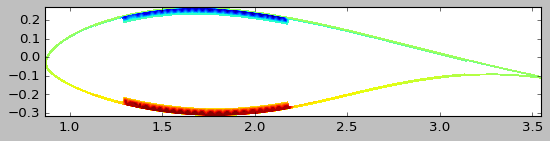

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
2


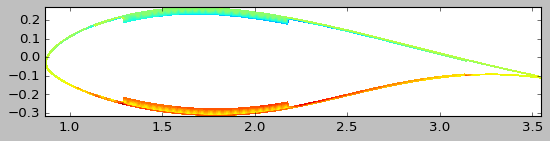

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
3


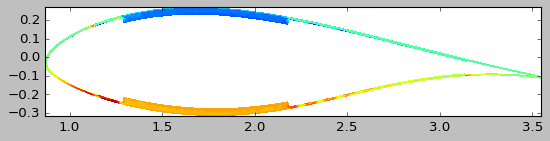

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
4


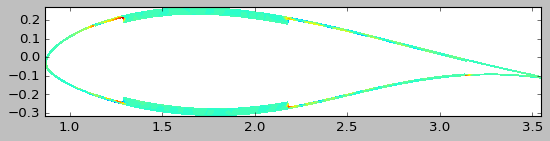

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
5


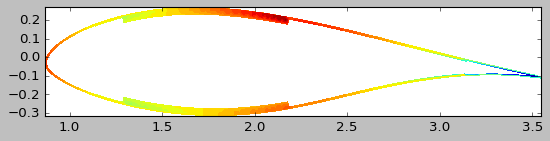

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
6


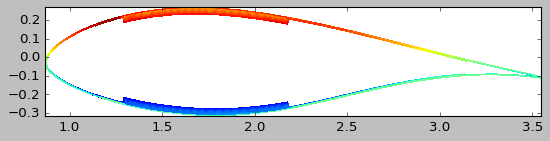

In [14]:
V = FunctionSpace(mesh, 'DG', 1)

for pp in range(6):    

    # Create functions in parts
    V0 = FunctionSpace(mesh, 'DG', 1)
    u0 = project(sigma_vec(st_3D,0)[pp], V0)

    V1 = FunctionSpace(mesh, 'DG', 1)
    u1 = project(sigma_vec(st_3D,1)[pp], V1)

    V2 = FunctionSpace(mesh, 'DG', 1)
    u2 = project(sigma_vec(st_3D,2)[pp], V2)

    V3 = FunctionSpace(mesh, 'DG', 1)
    u3 = project(sigma_vec(st_3D,3)[pp], V3)

    V4 = FunctionSpace(mesh, 'DG', 1)
    u4 = project(sigma_vec(st_3D,4)[pp], V4)

    # Begin glueing
    uu = TrialFunction(V)
    vv = TestFunction(V)
    aa = inner(uu, vv)*dx

    # Function v0 is u0 in mesh0 and 0 otherwise
    L0 = inner(u0, vv)*dx(0, subdomain_data=subdomains)
    v0 = Function(V)
    solve(aa == L0, v0)

    # Function v1 is u1 in mesh1 and 0 otherwise
    L1 = inner(u1, vv)*dx(1, subdomain_data=subdomains)
    v1 = Function(V)
    solve(aa == L1, v1)

    # Function v2 is u2 in mesh2 and 0 otherwise
    L2 = inner(u2, vv)*dx(2, subdomain_data=subdomains)
    v2 = Function(V)
    solve(aa == L2, v2)

    # Function v3 is u3 in mesh3 and 0 otherwise
    L3 = inner(u3, vv)*dx(3, subdomain_data=subdomains)
    v3 = Function(V)
    solve(aa == L3, v3)

    # Function v4 is u4 in mesh4 and 0 otherwise
    L4 = inner(u4, vv)*dx(4, subdomain_data=subdomains)
    v4 = Function(V)
    solve(aa == L4, v4)

    # Combine
    vvv = Function(V, v0.vector())
    vvv.vector()[:] += v1.vector()
    vvv.vector()[:] += v2.vector()
    vvv.vector()[:] += v3.vector()
    vvv.vector()[:] += v4.vector()
    plot(vvv)
    print(pp+1)
    plt.show()